In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Importo librerias de Scikit Learn
Puntualmente nos interesa importar el modelo de Regresion Lineal, la medida de error cuadratico medio, y el divisor de datos entre train y test.

In [79]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor as KN
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV

# Importo dataset de Airbnb 
Desde Airbnb obtenemos el siguiente dataset para entrenar nuestros modelos de regresion http://insideairbnb.com/get-the-data.html (dataset "listings.csv" de London). 

Objetivo: Vamos a querer predecir el precio dadas ciertas features.

In [3]:
pwd

'C:\\Users\\Usuario\\Google Drive\\2020\\Utn\\Ciencia de datos\\Clases\\clase_05'

In [4]:
# importo el dataset de Airbnb London, lo guardamos en el dataframe "london".
london = pd.read_csv(r"C:\Users\Usuario\Google Drive\2020\Utn\Ciencia de datos\Clases\clase_05\clusterai_regresion_dataset_airbnb_london.csv", delimiter=',', parse_dates = True)

In [5]:
# observo la cantidad de renglones y columnas del dataset importado
np.shape(london)

(75213, 16)

In [6]:
# exploro las columnas que tiene el dataframe importado
london.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [7]:
#visualizo los primeros 3 renglones de mi dataset
london.head(3)

id                                 name  host_id host_name  \
0   9554   Cozy, 3 minutes to Piccadilly Line    31655       Guy   
1  11076                        The Sanctuary    40471      Rosa   
2  13913  Holiday London DB Room Let-on going    54730     Alina   

   neighbourhood_group neighbourhood   latitude  longitude     room_type  \
0                  NaN      Haringey  51.587767  -0.105666  Private room   
1                  NaN        Ealing  51.515645  -0.314508  Private room   
2                  NaN     Islington  51.568017  -0.111208  Private room   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0     35               1                131  2018-08-03               1.71   
1     70               2                  2  2016-11-23               0.07   
2     45               1                 14  2018-06-17               0.14   

   calculated_host_listings_count  availability_365  
0                               4               262  
1                               6                62  
2                               2               364

In [8]:
# cuento cuantos NaNs tengo por columna
london.isnull().sum()

id                                    0
name                                 31
host_id                               0
host_name                            13
neighbourhood_group               75213
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       20353
reviews_per_month                 20357
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [9]:
# elimino las rows que tienen NaNs en la columna "reviews_per_month" , que otras opciones existen?
london = london.dropna(subset = ["reviews_per_month"])

In [10]:
# reviso como queda mi dataframe luego de eliminar los renglones con NaNs en review per month
london.shape

(54856, 16)

## Visualización rápida de las features de interes con Pairplot (Seaborn)

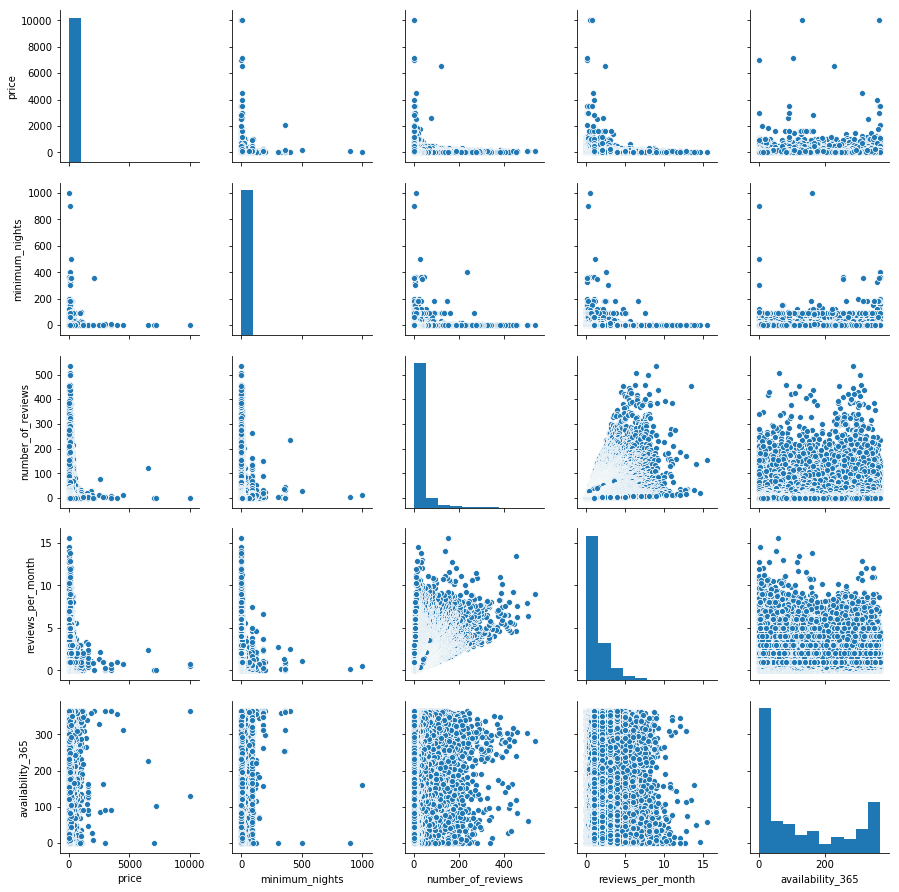

In [11]:
sns.pairplot(london[["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "availability_365"]])
plt.show()

## Elimino con .drop las columnas que no son de interes

In [12]:
london = london.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'last_review', 'latitude', 'longitude'], axis=1)
#Que features que eliminamos podrian llegar a ser utiles?

Link util -->
https://medium.com/@khadijamahanga/using-latitude-and-longitude-data-in-my-machine-learning-problem-541e2651e08c

In [13]:
london.head(3)

neighbourhood     room_type  price  minimum_nights  number_of_reviews  \
0      Haringey  Private room     35               1                131   
1        Ealing  Private room     70               2                  2   
2     Islington  Private room     45               1                 14   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               1.71                               4               262  
1               0.07                               6                62  
2               0.14                               2               364

## Reviso si los valores máximos de cada feature se condicen con el contexto

Con que objetivo queremos ver esta informacion?

In [14]:
np.max(london)

neighbourhood                     Westminster
room_type                         Shared room
price                                   10000
minimum_nights                           1000
number_of_reviews                         536
reviews_per_month                       15.56
calculated_host_listings_count           1034
availability_365                          365
dtype: object

## Obtengo los percentiles 97 de price y Minimum nights para filtrar outliers de estas features

In [15]:
price_q97 = london.price.quantile(0.975)
print("el cuantil 0.97 de la feature 'price' es = " + str(price_q97))

el cuantil 0.97 de la feature 'price' es = 300.0


In [16]:
min_nights_q97 = london.minimum_nights.quantile(0.975)
print("el cuantil 0.97 de la feature 'minimum_nights' es = " + str(min_nights_q97))

el cuantil 0.97 de la feature 'minimum_nights' es = 14.0


## Outlier Filtering: Filtro mi dataset por los percentiles calculados en el paso anterior bajo las features correspondientes

In [17]:
# aca filtro y conservo los valores que cumplen las dos condiciones al mismo tiempo
london_filt = london.loc[(london.price < price_q97) & (london.minimum_nights < min_nights_q97)]

In [18]:
london_filt.shape

(51827, 8)

In [19]:
london_filt.head(3)

neighbourhood     room_type  price  minimum_nights  number_of_reviews  \
0      Haringey  Private room     35               1                131   
1        Ealing  Private room     70               2                  2   
2     Islington  Private room     45               1                 14   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               1.71                               4               262  
1               0.07                               6                62  
2               0.14                               2               364

## Feature Engineering: Genero variables dummies para las features categoricas (Neighbourhood y Room Type)

In [20]:
# dummies para la feature "neighbourhood"
neighs_dummie = pd.get_dummies(london_filt.neighbourhood)
neighs_dummie.head(3)

Barking and Dagenham  Barnet  Bexley  Brent  Bromley  Camden  \
0                     0       0       0      0        0       0   
1                     0       0       0      0        0       0   
2                     0       0       0      0        0       0   

   City of London  Croydon  Ealing  Enfield     ...       Merton  Newham  \
0               0        0       0        0     ...            0       0   
1               0        0       1        0     ...            0       0   
2               0        0       0        0     ...            0       0   

   Redbridge  Richmond upon Thames  Southwark  Sutton  Tower Hamlets  \
0          0                     0          0       0              0   
1          0                     0          0       0              0   
2          0                     0          0       0              0   

   Waltham Forest  Wandsworth  Westminster  
0               0           0            0  
1               0           0            0  
2               0           0            0  

[3 rows x 33 columns]

In [21]:
neighs_dummie.shape

(51827, 33)

In [22]:
# Ejemplo de dummies para la feature "room_type"
room_dummie = pd.get_dummies(london_filt.room_type)
room_dummie.head(3)

Entire home/apt  Private room  Shared room
0                0             1            0
1                0             1            0
2                0             1            0

In [23]:
room_dummie.shape

(51827, 3)

## Agrego las nuevas variables dummies creadas al dataframe de trabajo 'london_filt'

In [24]:
london_filt = london_filt.join([neighs_dummie, room_dummie])

In [25]:
london_filt.head(3)

neighbourhood     room_type  price  minimum_nights  number_of_reviews  \
0      Haringey  Private room     35               1                131   
1        Ealing  Private room     70               2                  2   
2     Islington  Private room     45               1                 14   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               1.71                               4               262   
1               0.07                               6                62   
2               0.14                               2               364   

   Barking and Dagenham  Barnet     ...       Richmond upon Thames  Southwark  \
0                     0       0     ...                          0          0   
1                     0       0     ...                          0          0   
2                     0       0     ...                          0          0   

   Sutton  Tower Hamlets  Waltham Forest  Wandsworth  Westminster  \
0       0              0               0           0            0   
1       0              0               0           0            0   
2       0              0               0           0            0   

   Entire home/apt  Private room  Shared room  
0                0             1            0  
1                0             1            0  
2                0             1            0  

[3 rows x 44 columns]

In [26]:
print("La cantidad de features nuevas agregadas a dataframe son = " + str(np.shape(neighs_dummie)[1]+np.shape(room_dummie)[1]))

La cantidad de features nuevas agregadas a dataframe son = 36


## Creamos nuestra variable dependiente (label - etiqueta) y

In [27]:
y = np.array(london_filt[["price"]])

## Creamos nuestra variable Independiente X quitando las features que no deseamos

In [28]:
x = london_filt.drop(['price', 'neighbourhood','room_type'], axis=1)

In [29]:
np.shape(x)

(51827, 41)

## Divido el dataset entre Train y Test

In [30]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.90, random_state=42)

In [31]:
xtrain.head()

minimum_nights  number_of_reviews  reviews_per_month  \
4109                3                 10               0.61   
8703                1                  2               0.05   
62456               4                  1               0.94   
7200                2                  2               0.18   
44756               1                  3               0.25   

       calculated_host_listings_count  availability_365  Barking and Dagenham  \
4109                                1               321                     0   
8703                                1                 0                     0   
62456                               1               137                     0   
7200                                1                 0                     0   
44756                               1               220                     0   

       Barnet  Bexley  Brent  Bromley     ...       Richmond upon Thames  \
4109        0       0      0        0     ...                          0   
8703        0       0      0        0     ...                          0   
62456       0       0      0        0     ...                          0   
7200        0       0      0        0     ...                          0   
44756       0       0      0        0     ...                          0   

       Southwark  Sutton  Tower Hamlets  Waltham Forest  Wandsworth  \
4109           0       0              0               0           0   
8703           0       0              0               1           0   
62456          0       0              0               0           0   
7200           0       0              1               0           0   
44756          0       0              1               0           0   

       Westminster  Entire home/apt  Private room  Shared room  
4109             0                1             0            0  
8703             0                0             1            0  
62456            0                0             1            0  
7200             0                1             0            0  
44756            0                1             0            0  

[5 rows x 41 columns]

In [32]:
xtrain.shape

(5182, 41)

In [33]:
# Step 4: auto scaling train- set (mean = 0, std = 1)
scaler = preprocessing.StandardScaler().fit(xtrain)
scaler

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
# auto scalo mis muestras de train utilizando el scaler fiteado con el xtrain
xtrain_scal = scaler.transform(xtrain)  

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [35]:
# auto scalo mis muestras de test utilizando el scaler fiteado con el xtrain
xtest_scal = scaler.transform(xtest)  

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


# Creo un modelo de Regresión Lineal

In [36]:
# 1) creo un modelo generico de regresion lineal
lr = LinearRegression()

In [37]:
# 2) Ajusto el modelo de regresion lineal utilizando el set de train, tanto las features X como las samples Y
lr.fit(xtrain_scal, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [38]:
# 3) Obtengo las predicciones que realiza mi modelo con las muestras de test, sin mostrarle las labels (Ytest)
# las predicciones las guardo en el vector "ypred"
ypred = lr.predict(xtest_scal)

In [39]:
np.shape(ypred)

(46645, 1)

In [40]:
# calculo el error de mi modelo con las muestras de train = error de train
np.sqrt(mean_squared_error(ytest, ypred))

39.35249794978497

In [41]:
mean_squared_error(ytest, ypred)

1548.6190948878302

In [42]:
from sklearn.metrics import mean_absolute_error

In [43]:
mean_absolute_error(ytest, ypred)

28.161944024212815

![Inner join](https://i.imgflip.com/1vgxmu.jpg)

## Armar tres modelos de regresion usando:

    -KNN Regression
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros
    parameters_k = np.arange(20,31,5)
    parameters_knn = [{'n_neighbors': parameters_k}]
    
    https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html?highlight=knn
    
    -SVR
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros:
    ​parameters_svr_rbf = [{'kernel':['rbf'] , 'C': [1,100],'gamma': [0.1,0.5] }]
    
    -Random Forest regressor
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros:
    'n_estimators': [100, 200, 300, 1000]
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.set_params

### Comparar el R2, RMSE, MAE

Competencia

Mayor R2 = { }

Menor RMSE = { }

Menor MAE = { }

# SVR

In [105]:
# Ahora cambiamos el estimador, usaremos SVR
est = SVR(max_iter=25000)
# Lista del parametro lambda (parametro 'alpha')
parameters = {'kernel':['rbf'],'C' : [50,100],
             'gamma':[0.05,0.1,0.15]}
# Definimos nuevamente el objeto GS con los parametros previamente definidos
n_folds = 5
gs = GridSearchCV(est, param_grid=parameters,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)

In [106]:
# Entrenamos
gs.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  1.9min finished
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=25000, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'kernel': ['rbf'], 'C': [50, 100], 'gamma': [0.05, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

In [107]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

SVR(C=50, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.05,
  kernel='rbf', max_iter=25000, shrinking=True, tol=0.001, verbose=False) 

{'C': 50, 'gamma': 0.05, 'kernel': 'rbf'} 

-1632.0673765170225 



In [108]:
y_pred=gs.predict(xtest_scal)

In [109]:
# Prediccion + Metricas
svr_prediction = gs.best_estimator_.predict(xtest_scal)
svr_r2 = r2_score(y_true=ytest, y_pred=svr_prediction)


In [110]:
svr_r2

0.49317527919000237

In [111]:
svr_mse = mean_squared_error(y_true=ytest, y_pred=svr_prediction)
svr_mae = mean_absolute_error(y_true=ytest, y_pred=svr_prediction)


# Prediccion + Metricas
#svr_prediction = gs.best_estimator_.predict(xtest_scal)
#svr_r2 = r2_score(y_true=ytest, y_pred=svr_prediction)
#svr_mse = mean_squared_error(y_true=ytest, y_pred=svr_prediction)
#svr_mae = mean_absolute_error(y_true=ytest, y_pred=svr_prediction)

In [112]:
svr_mse

1587.404812938179

In [113]:
svr_mae

26.61466483189176

# KKN

In [93]:
# Ahora cambiamos el estimador, usaremos SVR
est_kkn = KN()
# Lista del parametro lambda (parametro 'alpha')
parameters_k = np.arange(20,31,5)
parameters_knn = [{'n_neighbors': parameters_k}]
# Definimos nuevamente el objeto GS con los parametros previamente definidos
n_folds = 5
gs = GridSearchCV(est_kkn, param_grid=parameters_knn,refit=True,
                  cv=n_folds, scoring="neg_mean_squared_error",
                  verbose=3, n_jobs=3)

In [94]:
# Entrenamos
gs.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   18.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid=[{'n_neighbors': array([20, 25, 30])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

In [95]:
print(gs.best_estimator_, "\n")
print(gs.best_params_, "\n")
print(gs.best_score_, "\n")

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=20, p=2,
          weights='uniform') 

{'n_neighbors': 20} 

-1633.0379477035892 



In [96]:
y_pred=gs.predict(xtest_scal)

In [98]:
# Prediccion + Metricas
kkn_prediction = gs.best_estimator_.predict(xtest_scal)
kkn_r2 = r2_score(y_true=ytest, y_pred=kkn_prediction)
kkn_mse = mean_squared_error(y_true=ytest, y_pred=kkn_prediction)
kkn_mae = mean_absolute_error(y_true=ytest, y_pred=kkn_prediction)

In [99]:
svr_r2

0.49343204328146584

In [100]:
svr_mse

1586.6006127130454

In [101]:
svr_mae

28.06733840711759